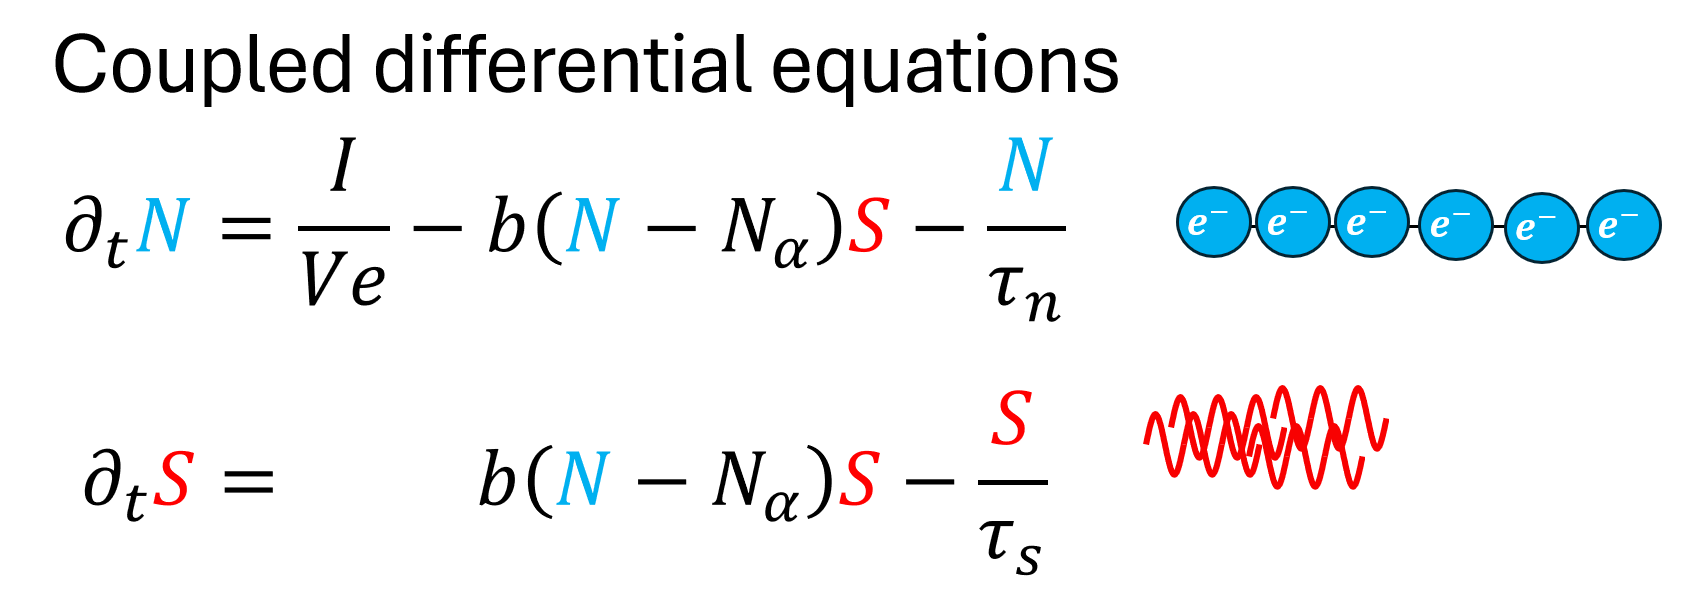

In [ ]:
import numpy as np
import numpy.typing as npt
from numpy.random import poisson
from scipy.integrate import solve_ivp
from dataclasses import dataclass
from scipy.constants import pi, c, h, e
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
def get_freq_range_from_time(time_s: npt.NDArray[float]
                             ) -> npt.NDArray[float]:
    """
    Calculate frequency range for spectrum based on time basis.

    When plotting a discretized pulse signal as a function of time,
    a time range is needed. To plot the spectrum of the pulse, one
    can compute the FFT and plot it versus the frequency range
    calculated by this function

    Parameters
    ----------
    time_s : npt.NDArray[float]
        Time range in seconds.

    Returns
    -------
    npt.NDArray[float]
        Frequency range in Hz.

    """
    return fftshift(fftfreq(len(time_s), d=time_s[1] - time_s[0]))


def get_time_from_freq_range(frequency_Hz: npt.NDArray[float]
                             ) -> npt.NDArray[float]:
    """
    Calculate time range for pulse based on frequency range.

    Essentially the inverse of the get_freq_range_from_time function.
    If we have a frequency range and take the iFFT of a spectrum field
    to get the pulse field in the time domain, this function provides the
    appropriate time range.

    Parameters
    ----------
    frequency_Hz : npt.NDArray[float]
        Freq. range in Hz.

    Returns
    -------
    time_s : npt.NDArray[float]
        Time range in s.

    """

    time_s = fftshift(fftfreq(len(frequency_Hz),
                              d=frequency_Hz[1] - frequency_Hz[0]))
    return time_s


def get_spectrum_from_pulse(time_s: npt.NDArray[float],
                            pulse_field: npt.NDArray[complex],
                            FFT_tol: float = 1e-7) -> npt.NDArray[complex]:
    """

    Parameters
    ----------
    time_s : npt.NDArray[float]
        Time range in seconds.
    pulse_field: npt.NDArray[complex]
        Complex field of pulse in time domain in units of sqrt(W).
    FFT_tol : float, optional
        When computing the FFT and going from temporal to spectral domain, the
        energy (which theoretically should be conserved) cannot change
        fractionally by more than FFT_tol. The default is 1e-7.

    Returns
    -------
    spectrum_field : npt.NDArray[complex]
        Complex spectral field in units of sqrt(J/Hz).

    """

    pulseEnergy = get_energy(time_s, pulse_field)  # Get pulse energy
    f = get_freq_range_from_time(time_s)
    dt = time_s[1] - time_s[0]

    assert dt > 0, (f"ERROR: dt must be positive, "
                    f"but {dt=}. {time_s[1]=},{time_s[0]=}")
    spectrum_field = ifftshift(
        ifft(ifftshift(pulse_field))) * (dt*len(f))  # Do shift and take fft
    spectrumEnergy = get_energy(f, spectrum_field)  # Get spectrum energy

    err = np.abs((pulseEnergy / spectrumEnergy - 1))


    assert (
        err < FFT_tol
    ), (f"ERROR = {err:.3e} > {FFT_tol:.3e} = FFT_tol : Energy changed "
        "when going from Pulse to Spectrum!!!")

    return spectrum_field


def get_pulse_from_spectrum(frequency_Hz: npt.NDArray[float],
                            spectrum_field: npt.NDArray[complex],
                            FFT_tol: float = 1e-7) -> npt.NDArray[complex]:
    """
    Converts the spectral field of a signal in the freq. domain temporal
    field in time domain

    Uses the iFFT to shift from freq. to time domain and ensures that energy
    is conserved

    Parameters
    ----------
    frequency_Hz : npt.NDArray[float]
        Frequency in Hz.
    spectrum_field : npt.NDArray[complex]
        Spectral field in sqrt(J/Hz).
    FFT_tol : float, optional
        Maximum fractional change in signal
        energy when doing FFT. The default is 1e-7.

    Returns
    -------
    pulse : npt.NDArray[complex]
        Temporal field in sqrt(W).

    """

    spectrumEnergy = get_energy(frequency_Hz, spectrum_field)

    time = get_time_from_freq_range(frequency_Hz)
    dt = time[1] - time[0]

    pulse = fftshift(fft(fftshift(spectrum_field))) / (dt*len(time))
    pulseEnergy = get_energy(time, pulse)

    err = np.abs((pulseEnergy / spectrumEnergy - 1))



    assert (
        err < FFT_tol
    ), (f"ERROR = {err:.3e} > {FFT_tol:.3e} = FFT_tol : Energy changed too "
        "much when going from Spectrum to Pulse!!!")
    return pulse

def get_power(field_in_time_or_freq_domain: npt.NDArray[complex]
              ) -> npt.NDArray[float]:
    """
    Computes temporal power or PSD

    For a real electric field, power averaged over an optical cycle is

    P = 1/T int_0^T( E_real**2 )dt.

    For a complex electric field, this same power is calculated as

    P = 0.5*|E|**2.

    Using the complex field makes calculations easier and the factor of
    0.5 is simply absorbed into the nonlinear parameter, gamma.
    Same thing works in the frequency domain.

    Parameters
    ----------
    field_in_time_or_freq_domain : npt.NDArray[complex]
        Temporal or spectral field.

    Returns
    -------
    power : npt.NDArray[complex]
        Temporal power (W) or PSD (J/Hz) at any instance or frequency.

    """
    power = np.abs(field_in_time_or_freq_domain) ** 2
    return power

def get_energy(
    time_or_freq: npt.NDArray[float],
    field_in_time_or_freq_domain: npt.NDArray[complex],
) -> float:
    """
    Computes energy of signal or spectrum

    Gets the power or PSD of the signal from
    get_power(field_in_time_or_freq_domain)
    and integrates it w.r.t. either time or
    frequency to get the energy.

    Parameters
    ----------
    time_or_freq : npt.NDArray[float]
        Time range in seconds or freq. range in Hz.
    field_in_time_or_freq_domain : npt.NDArray[complex]
        Temporal field in [sqrt(W)] or spectral field [sqrt(J/Hz)].

    Returns
    -------
    energy: float
        Signal energy in J .

    """
    energy = np.trapz(
        get_power(field_in_time_or_freq_domain), time_or_freq)
    return energy


rcParams['figure.dpi'] = 300
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 3

    
    







In [ ]:
#Cavity dimensions
cavity_length_m = 248e-6 #248um length.  EOP page 926. 
cavity_width = 7e-6 # 7um width.  EOP page 926. 
cavity_height = 0.2e-6 # 0.2um height.  EOP page 926. 
cavity_volume =cavity_length_m*cavity_width*cavity_height

#Cavity loss properties
mirror_reflectivity = 0.31 #Typical value when no mirrors are placed on cavity ends; Pure Fresnel reflection for GaAs vs air.. EOP 907
cavity_refractive_index = 3.5 #Typical value for GaAs. EOP page 926
cavity_speed_of_light_m_per_s = c/cavity_refractive_index
loss_coeff = 17500 #per m. From EOP page 928

#Characteristic lifetimes
tau_n=2.65e-9 #Charge lifetime in conduction band. EOP page 926. 
tau_s = 1/(cavity_speed_of_light_m_per_s*(loss_coeff-np.log(mirror_reflectivity)/cavity_length_m)) #Photons in cavity
print(f"tau_n={tau_n/1e-9:.4f}ns, tau_s={tau_s/1e-12:.4f}ps")
print(f"tau_n/tau_s={tau_n/tau_s}")


gain_slope_per_m_per_m3=3.37e-20# 3.37e-16/cm/(charges per cm^3) =3.37e-20/m/(charges per m^3) Must be multiplied by (N-Na) [m^(-3)] to get actual gain in 1/m. EOP page 928. 
Na = 1.2e24 #Charge density per m^3 required for gain to be equal to zero. 
b=cavity_speed_of_light_m_per_s*gain_slope_per_m_per_m3
N_th=Na+1/(b*tau_s)
print(f"Lasing threshold charge density {N_th = }per m^3")
print(f"Zero gain charge density {Na = } per m^3")

I_th = (Na+1/b/tau_s)/tau_n*cavity_volume*e
Ia = Na/tau_n*cavity_volume*e

print(f"I_th ={I_th/1e-3 :.3f}mA")
print(f"Ia ={Ia/1e-3 :.3f}mA")





In [ ]:
def update_S_and_N(t,z,b,I_per_Ve,Na,tau_n,tau_s):
    N,S = z
    return [I_per_Ve-b*(N-Na)*S-N/tau_n,b*(N-Na)*S-S/tau_s]
    


b,I,Na,tau_n,tau_s = b,I_th*2, Na,tau_n,tau_s
td=tau_n*np.log(1/(1-I_th/I))
S_ss = tau_s*(I-I_th)/cavity_volume/e
gamma = (b*S_ss+1/tau_n)
omega_r = np.sqrt(b**2*S_ss*(N_th-Na))

print(f"sqrt(1-(gamma/2/wr)**2)={np.sqrt(1-(gamma/2/omega_r)**2)}")

f_r_Hz = omega_r/2/np.pi
print(f"gamma={gamma/1e9}GHz, f_r={f_r_Hz/1e9}GHz")

t_range = [0, td*40]
N_start = 1 #Choose non-zero starting values
S_start = 1
start_vals = [N_start,S_start]


sol = solve_ivp(update_S_and_N, 
                t_range, 
                start_vals, 
                args=(b,
                      I/cavity_volume/e,
                      Na,
                      tau_n,
                      tau_s),
                dense_output=True)

t = np.linspace(t_range[0], t_range[1], 2**15)
dt=t[1]-t[0]
z = sol.sol(t)
fig,ax=plt.subplots()
ax.plot(t/1e-9, z.T[:,0],label='N',color='c')
ax.axhline(y=N_th,color='b',alpha=0.5,label='$N_{th}$')
ax.plot(t/1e-9, z.T[:,1]*100,label='S*100',color='r')
ax.axhline(y=S_ss*100,color='r',alpha=0.5,label='$S_{ss}*100$')
ax.axvline(x=td/1e-9,label='$t_d$')
ax.axhline(y=Na,color='C0',alpha=0.5,label="$N_a$")
ax.set_xlim(0,td/1e-9*3)
#ax.legend()
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Density [$m^{-3}$]')
plt.show()

fig,ax=plt.subplots()
ax.plot(t/1e-9, z.T[:,0],label='N',color='c')
ax.axhline(y=N_th,color='b',alpha=0.5,label='$N_{th}$')
ax.plot(t/1e-9, z.T[:,1]*100,label='S*100',color='r')
ax.axhline(y=S_ss*100,color='r',alpha=0.5,label='$S_{ss}$*100')
ax.set_xlim(0,td/1e-9*3)
ax.axvline(x=td/1e-9,label='$t_d$')
ax.axhline(y=Na,color='C0',alpha=0.5,label="$N_a$")
#ax.set_ylim(1e13,1e19)
#ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Density [$m^{-3}$]')
plt.show()





In [ ]:
fig,ax=plt.subplots()
#ax.plot(t/1e-9, z.T[:,0],label='N',color='c')
#ax.axhline(y=N_th,color='b',alpha=0.5,label='$N_{th}$')
ax.plot(t/1e-9, z.T[:,1],label='S',color='r',linewidth=1)
#ax.axhline(y=S_ss,color='r',alpha=0.5,label='$S_{ss}$')
#ax.axvline(x=td/1e-9,label='$t_d$')
#ax.axhline(y=Na,color='C0',alpha=0.5,label="$N_a$")
ax.set_xlim(0,td/1e-9*6)
ax.legend()
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Density [$m^{-3}$]')
plt.show()


fig,ax=plt.subplots()
ax.plot(z.T[:,0], z.T[:,1],color='C2',linewidth=0.2,label='Phase space trajectory')
ax.set_xlim(N_th*0.75,1.05*np.max(z.T[:,0]))
ax.axvline(x=N_th,color='b',alpha=0.5,label='$N_{th}$')
ax.axhline(y=S_ss,color='r',alpha=0.5,label='$S_{ss}$')
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('S')
ax.yaxis.label.set_color('red')
ax.xaxis.label.set_color('c')
plt.show()

fig,ax=plt.subplots()
ax.plot(z.T[:,0], z.T[:,1],color='C2',linewidth=0.2,label='Phase space trajectory')
ax.set_xlim(N_th*0.75,1.05*np.max(z.T[:,0]))
ax.axvline(x=N_th,color='b',alpha=0.5,label='$N_{th}$')
ax.axhline(y=S_ss,color='r',alpha=0.5,label='$S_{ss}$')
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('S')
ax.yaxis.label.set_color('red')
ax.xaxis.label.set_color('c')
ax.set_ylim(0,S_ss*3)
ax.set_xlim(N_th*0.97,N_th*1.02)
plt.show()


In [ ]:
def relative_photon_noise(fm,fr,g,tau_s,S_ss,i_0_per_VE):
    return i_0_per_VE*tau_s/S_ss/np.sqrt(   ( (fm/fr)**2-1  )**2+(g*fm/fr**2)**2  )

percentage_start = 0.45
idx_start=int(len(t)*percentage_start) 
t_zoom = t[idx_start::]

#Note: Need to apply windowing in time domain due to "spectral leakage". Basically, because I am
#extracting a certain range of time whose resolution is chosen independently of s(t) and its resonance 
#frequency, this central frequency does not necessarily "line up" with one of the frequency bins
#used by the FFT. With good "line up", sidelobes of the sinc function for the resonance frequency will be
#zero at all other bins, buth with bad "line up", they will "spill over" into all other bins. Applying
#a window in the time domain makes the effect less pronounced when plotting. 

filt = np.exp(-0.5*np.abs((t_zoom-np.mean(t_zoom))*1.53*gamma)**20)

fig,ax=plt.subplots()
ax.set_title(f"Time resolution = {(t[1]-t[0])/1e-12:.3f}ps")
ax.plot(t_zoom/1e-9, z.T[idx_start::,1]-S_ss,label='S-$S_{SS}$',color='r',linewidth=0.5)
ax2=ax.twinx()
ax2.plot(t_zoom/1e-9, filt,label='Filter',color='g',linewidth=0.5)
ax.legend()
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Density [$m^{-3}$]')
plt.show()


fig,ax=plt.subplots()
ax.set_title('Variation in photon density after saturation')
ax.plot(t_zoom/1e-9, z.T[idx_start::,1]-S_ss,label='S-$S_{SS}$',color='r')
ax.legend()
ax.set_xlim(t_zoom[0]/1e-9,t_zoom[int(len(t_zoom)/20)]/1e-9)
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Density [$m^{-3}$]')
plt.show()

f=get_freq_range_from_time(t_zoom)
df=f[1]-f[0]

S_ss_numerical = np.mean(z.T[idx_start::,1])
s=z.T[idx_start::,1]-S_ss_numerical
RIN_T =s/S_ss_numerical 
RIN_F = np.abs(get_spectrum_from_pulse(t_zoom,RIN_T*filt ,FFT_tol=1e-3 )  )**2*df
F=f[int(len(f)/2+2):-1]

#Average number of charges arriving during 1s = I/e
#Stdev of number of arriving charges according to Poisson distribution = sqrt(I/e*1s)
#Stdev of current in charges/volume/s = sqrt(I/e*1s)/V/1s

i0_per_Ve = np.sqrt(I/e*1)/cavity_volume/1
RIN_F_theory = np.abs(relative_photon_noise(F,f_r_Hz,gamma,tau_s,S_ss,i0_per_Ve))**2

fig,ax=plt.subplots()
ax.set_title(f"Freq. resolution = {(df)/1e6:.3f}MHz")
ax.plot(F/1e9, 10*np.log10(2*RIN_F[int(len(f)/2+2):-1]),'-',label='FT$\{RIN_T\}$',color='r',alpha=0.5)
ax.plot(F/1e9, 10*np.log10(2*RIN_F_theory),'-',label='FT$\{RIN_T\} theory$',color='m',alpha=0.5)
ax.axvline(x=omega_r/2/np.pi/1e9,color='C5',alpha=0.5,label=f'fr={f_r_Hz/1e9:.3}GHz')
ax.legend()
ax.set_xlim(3*F[0]/1e9,15*f_r_Hz/1e9)
#ax.set_ylim(-190,3+np.max(10*np.log10(2*RIN_F[int(len(f)/2+2):-1])))

ax.set_xlabel('Freq. [GHz]')
ax.set_ylabel('RIN_F [dBc/Hz]')
ax.set_xscale('log')
plt.show()


In [ ]:

def td(x):
    return np.log(1/(1-1/x))

def td_with_bias(x,xb):
    return np.log( (x-xb)/(x-1) )

In [ ]:
x=np.linspace(1.001,5,1000)


fig,ax=plt.subplots()
ax.plot(x,td(x))
ax.set_xlabel('I/$I_{th}$')
ax.set_ylabel('$t_d/\\tau_n$')
plt.show()

fig,ax=plt.subplots()
ax.plot(x,td_with_bias(x,0.0),label='$I_b=0.0I_{th}$', color='C0')

ax.plot(x,td_with_bias(x,0.5),label='$I_b=0.5I_{th}$', color='C1')
ax.plot(x,td_with_bias(x,0.75),label='$I_b=0.75I_{th}$', color='C2')
ax.plot(x,td_with_bias(x,0.95),label='$I_b=0.95I_{th}$', color='C3')
ax.plot(x,td_with_bias(x,0.99),label='$I_b=0.99I_{th}$', color='C4')

ax.set_xlabel('I/$I_{th}$')
ax.set_ylabel('$t_d/\\tau_n$')
plt.legend()
plt.show()


fig,ax=plt.subplots()
ax.plot(x,td_with_bias(x,0.0)/td(x),label='$I_b=0.0I_{th}$', color='C0')

ax.plot(x,td_with_bias(x,0.5)/td(x),label='$I_b=0.5I_{th}$', color='C1')
ax.plot(x,td_with_bias(x,0.75)/td(x),label='$I_b=0.75I_{th}$', color='C2')
ax.plot(x,td_with_bias(x,0.95)/td(x),label='$I_b=0.95I_{th}$', color='C3')
ax.plot(x,td_with_bias(x,0.99)/td(x),label='$I_b=0.99I_{th}$', color='C4')

ax.set_xlabel('I/$I_{th}$')
ax.set_ylabel('td with bias / td without bias')
ax.set_yscale('log')
ax.set_ylim(1e-2,5e0)
plt.legend()
plt.show()



In [ ]:
fr=5
fm=np.linspace(0,15,1000)
g=1

y1=relative_photon_noise(fm,fr,g,tau_s,S_ss,i0_per_Ve)
y2=relative_photon_noise(fm,fr*1.5,g,tau_s,S_ss,i0_per_Ve)
y3=relative_photon_noise(fm,fr,g*1.5,tau_s,S_ss,i0_per_Ve)

fig,ax=plt.subplots()
ax.plot(fm,y1,label=f"$f_r$={fr:.1f}GHz, $\gamma$={g:.1f}GHz ")
ax.plot(fm,y2,label=f"$f_r$={1.5*fr:.1f}GHz, $\gamma$={g:.1f}GHz ")
ax.plot(fm,y3,label=f"$f_r$={fr:.1f}GHz, $\gamma$={1.5*g:.1f}GHz ")
ax.set_xlabel('Current modulation frequency [GHz]')
ax.set_ylabel('Photon number variation amplitude')
plt.legend()
plt.show()

fig,ax=plt.subplots()
ax.plot(fm,y1,label=f"$f_r$={fr:.1f}GHz, $\gamma$={g:.1f}GHz ")
ax.plot(fm,y2,label=f"$f_r$={1.5*fr:.1f}GHz, $\gamma$={g:.1f}GHz ")
ax.plot(fm,y3,label=f"$f_r$={fr:.1f}GHz, $\gamma$={1.5*g:.1f}GHz ")
ax.set_xlabel('Current modulation frequency [GHz]')
ax.set_ylabel('Photon number variation amplitude')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.show()



In [ ]:


time=np.linspace(0,10,1000)

mean = 100
gauss=np.random.poisson(mean,len(time))

fig,ax=plt.subplots()
ax.plot(time,gauss,label='Actual Current')
ax.axhline(y=mean,label='Mean Current',color='C1')
ax.set_ylim(0,mean+7*np.sqrt(mean))
ax.set_xlabel('Time [a.u.]')
ax.set_ylabel('Current [# of electrons]')
ax.legend()
plt.show()


y=fftshift(fft(gauss-np.mean(gauss)))

fig,ax=plt.subplots()
ax.plot(np.abs(y[int(len(y)/2):-1]))
ax.axhline(y=np.mean(np.abs(y)),label='Mean Current spectrum',color='C1')
ax.set_xlabel('Freq. [a.u.]')
ax.set_ylabel('$|FT\{I(t)\}|$')
ax.legend()

plt.show()